In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
PROJECT_ROOT = "/content/drive/MyDrive/CSE425_VAE_Project"
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print("Added to sys.path:", PROJECT_ROOT)


Added to sys.path: /content/drive/MyDrive/CSE425_VAE_Project


In [ ]:
DATA = "/content/drive/MyDrive/CSE425_VAE_Project/data/raw/merge"
zip_path = f"{DATA}/MERGE_Bimodal_Balanced.zip"

!unzip -o "{zip_path}" -d "{DATA}"


Archive:  /content/drive/MyDrive/CSE425_VAE_Project/data/raw/merge/MERGE_Bimodal_Balanced.zip
  inflating: /content/drive/MyDrive/CSE425_VAE_Project/data/raw/merge/MERGE_Bimodal_Balanced/audio/Q1/A005.mp3  
  inflating: /content/drive/MyDrive/CSE425_VAE_Project/data/raw/merge/MERGE_Bimodal_Balanced/audio/Q1/A011.mp3  
  inflating: /content/drive/MyDrive/CSE425_VAE_Project/data/raw/merge/MERGE_Bimodal_Balanced/audio/Q1/A014.mp3  
  inflating: /content/drive/MyDrive/CSE425_VAE_Project/data/raw/merge/MERGE_Bimodal_Balanced/audio/Q1/A019.mp3  
  inflating: /content/drive/MyDrive/CSE425_VAE_Project/data/raw/merge/MERGE_Bimodal_Balanced/audio/Q1/A024.mp3  
  inflating: /content/drive/MyDrive/CSE425_VAE_Project/data/raw/merge/MERGE_Bimodal_Balanced/audio/Q1/A039.mp3  
  inflating: /content/drive/MyDrive/CSE425_VAE_Project/data/raw/merge/MERGE_Bimodal_Balanced/audio/Q1/A042.mp3  
  inflating: /content/drive/MyDrive/CSE425_VAE_Project/data/raw/merge/MERGE_Bimodal_Balanced/audio/Q1/A043.mp3  
  

In [ ]:
import os
import pandas as pd

ROOT = "/content/drive/MyDrive/CSE425_VAE_Project/data/raw/merge/MERGE_Bimodal_Balanced"
OUT  = "/content/drive/MyDrive/CSE425_VAE_Project/data/processed"
os.makedirs(OUT, exist_ok=True)

rows = []

audio_root = os.path.join(ROOT, "audio")
lyrics_root = os.path.join(ROOT, "lyrics")

for quadrant in ["Q1", "Q2", "Q3", "Q4"]:
    audio_dir = os.path.join(audio_root, quadrant)
    lyrics_dir = os.path.join(lyrics_root, quadrant)

    audio_files = {
        os.path.splitext(f)[0]: os.path.join(audio_dir, f)
        for f in os.listdir(audio_dir)
        if f.lower().endswith((".wav", ".mp3", ".flac"))
    }

    lyrics_files = {
        os.path.splitext(f)[0]: os.path.join(lyrics_dir, f)
        for f in os.listdir(lyrics_dir)
        if f.lower().endswith(".txt")
    }

    common_ids = sorted(set(audio_files) & set(lyrics_files))

    for tid in common_ids:
        rows.append({
            "track_id": tid,
            "audio_path": audio_files[tid],
            "lyrics_path": lyrics_files[tid],
            "quadrant": quadrant
        })

tracks = pd.DataFrame(rows)
tracks.to_csv(os.path.join(OUT, "tracks.csv"), index=False)

print("tracks.csv created")
print("Total samples:", len(tracks))
print(tracks.head())


tracks.csv created
Total samples: 1914
       track_id                                         audio_path  \
0  MT0000040773  /content/drive/MyDrive/CSE425_VAE_Project/data...   
1  MT0000045345  /content/drive/MyDrive/CSE425_VAE_Project/data...   
2  MT0000080053  /content/drive/MyDrive/CSE425_VAE_Project/data...   
3  MT0000091401  /content/drive/MyDrive/CSE425_VAE_Project/data...   
4  MT0000093583  /content/drive/MyDrive/CSE425_VAE_Project/data...   

                                         lyrics_path quadrant  
0  /content/drive/MyDrive/CSE425_VAE_Project/data...       Q1  
1  /content/drive/MyDrive/CSE425_VAE_Project/data...       Q1  
2  /content/drive/MyDrive/CSE425_VAE_Project/data...       Q1  
3  /content/drive/MyDrive/CSE425_VAE_Project/data...       Q1  
4  /content/drive/MyDrive/CSE425_VAE_Project/data...       Q1  


In [ ]:
from src.dataset import MergeAudioDataset

ds = MergeAudioDataset("/content/drive/MyDrive/CSE425_VAE_Project/data/processed/tracks.csv")
x, q = ds[0]
print(x.shape, x.min().item(), x.max().item(), q)


torch.Size([1, 128, 128]) 0.0 1.0 tensor(0)


In [ ]:
import torch
import torch.nn.functional as F

def cvae_loss(x, x_hat, mu, logvar, beta=4.0):
    recon = F.mse_loss(x_hat, x, reduction="sum")
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl


In [ ]:
import os, numpy as np, pandas as pd, librosa
from tqdm import tqdm

tracks_csv = "/content/drive/MyDrive/CSE425_VAE_Project/data/processed/tracks.csv"
out_dir    = "/content/drive/MyDrive/CSE425_VAE_Project/data/processed"
mels_path  = f"{out_dir}/mels_1x128x128.npy"
q_path     = f"{out_dir}/quadrants.npy"

df = pd.read_csv(tracks_csv)
X = np.zeros((len(df), 1, 128, 128), dtype=np.float32)
q_map = {"Q1":0, "Q2":1, "Q3":2, "Q4":3}
Q = np.zeros((len(df),), dtype=np.int64)

for i, row in tqdm(df.iterrows(), total=len(df)):
    y, sr = librosa.load(row.audio_path, sr=22050, mono=True)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
    mel = librosa.power_to_db(mel, ref=np.max)

    mel = mel[:, :128]
    if mel.shape[1] < 128:
        mel = np.pad(mel, ((0,0),(0,128-mel.shape[1])), mode="constant")

    mel = (mel - mel.min()) / (mel.max() - mel.min() + 1e-8)
    X[i, 0] = mel.astype(np.float32)
    Q[i] = q_map[str(row.quadrant).strip()]

np.save(mels_path, X)
np.save(q_path, Q)

print("Saved:", mels_path, X.shape)
print("Saved:", q_path, Q.shape)


100%|██████████| 1914/1914 [04:22<00:00,  7.30it/s]


Saved: /content/drive/MyDrive/CSE425_VAE_Project/data/processed/mels_1x128x128.npy (1914, 1, 128, 128)
Saved: /content/drive/MyDrive/CSE425_VAE_Project/data/processed/quadrants.npy (1914,)


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset

class PrecomputedMelDataset(Dataset):
    def __init__(self, mels_path, q_path):
        self.X = np.load(mels_path)  # (N, 1, 128, 128)
        self.Q = np.load(q_path)     # (N,)

    def __len__(self):
        return len(self.Q)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).float()     # (1,128,128)
        q = torch.tensor(self.Q[idx], dtype=torch.long)
        return x, q


In [ ]:
dataset = PrecomputedMelDataset(
    "/content/drive/MyDrive/CSE425_VAE_Project/data/processed/mels_1x128x128.npy",
    "/content/drive/MyDrive/CSE425_VAE_Project/data/processed/quadrants.npy"
)
x, q = dataset[0]
print(x.shape, x.min().item(), x.max().item(), q)

torch.Size([1, 128, 128]) 0.0 1.0 tensor(0)


In [ ]:
from torch.utils.data import DataLoader

loader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Encoder, Decoder, and CNN_CVAE classes
class Encoder(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) # 128 -> 64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # 64 -> 32
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # 32 -> 16
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) # 16 -> 8
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1) # 8 -> 4
        self.fc_mu = nn.Linear(512 * 4 * 4 + num_classes, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4 + num_classes, latent_dim)

    def forward(self, x, q):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(x.size(0), -1) # Flatten

        # One-hot encode the quadrant and concatenate
        q_onehot = F.one_hot(q, num_classes=4).float() # Assuming 4 quadrants
        x = torch.cat([x, q_onehot], dim=1)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(latent_dim + num_classes, 512 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1) # 4 -> 8
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1) # 8 -> 16
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # 16 -> 32
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # 32 -> 64
        self.deconv5 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1) # 64 -> 128

    def forward(self, z, q):
        q_onehot = F.one_hot(q, num_classes=4).float()
        z = torch.cat([z, q_onehot], dim=1)

        x = self.fc(z)
        x = x.view(x.size(0), 512, 4, 4) # Reshape
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        x = torch.sigmoid(self.deconv5(x)) # Output a probability map (0-1)
        return x

class CNN_CVAE(nn.Module):
    def __init__(self, latent_dim, num_classes=4): # Assuming 4 quadrants
        super().__init__()
        self.encoder = Encoder(latent_dim, num_classes)
        self.decoder = Decoder(latent_dim, num_classes)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, q):
        mu, logvar = self.encoder(x, q)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z, q)
        return x_hat, mu, logvar, z

device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = PrecomputedMelDataset(
    "/content/drive/MyDrive/CSE425_VAE_Project/data/processed/mels_1x128x128.npy",
    "/content/drive/MyDrive/CSE425_VAE_Project/data/processed/quadrants.npy"
)

loader = DataLoader(
    dataset,
    batch_size=128,          # larger batch now possible
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

model = CNN_CVAE(latent_dim=32).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(60):
    total_loss = 0.0
    for x, q in loader:
        x = x.to(device, non_blocking=True)
        q = q.to(device, non_blocking=True)

        x_hat, mu, logvar, _ = model(x, q)
        loss = cvae_loss(x, x_hat, mu, logvar, beta=4.0)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: loss = {total_loss/len(dataset):.4f}")


Epoch 1: loss = 765.1522
Epoch 2: loss = 440.1243
Epoch 3: loss = 356.9655
Epoch 4: loss = 319.7963
Epoch 5: loss = 297.9917
Epoch 6: loss = 278.9741
Epoch 7: loss = 257.6593
Epoch 8: loss = 244.7524
Epoch 9: loss = 237.5456
Epoch 10: loss = 236.3543
Epoch 11: loss = 234.1210
Epoch 12: loss = 229.7430
Epoch 13: loss = 224.5810
Epoch 14: loss = 221.0358
Epoch 15: loss = 219.0755
Epoch 16: loss = 217.8320
Epoch 17: loss = 217.0610
Epoch 18: loss = 215.9489
Epoch 19: loss = 216.2416
Epoch 20: loss = 214.5123
Epoch 21: loss = 214.0317
Epoch 22: loss = 212.8588
Epoch 23: loss = 213.0122
Epoch 24: loss = 212.3958
Epoch 25: loss = 212.3702
Epoch 26: loss = 211.9573
Epoch 27: loss = 211.6178
Epoch 28: loss = 210.7002
Epoch 29: loss = 210.9747
Epoch 30: loss = 210.4150
Epoch 31: loss = 209.3899
Epoch 32: loss = 210.0885
Epoch 33: loss = 209.5205
Epoch 34: loss = 209.2797
Epoch 35: loss = 208.3676
Epoch 36: loss = 208.5838
Epoch 37: loss = 208.0645
Epoch 38: loss = 207.9858
Epoch 39: loss = 208.

In [ ]:
import numpy as np
import torch
from tqdm import tqdm

model.eval()

Z_list = []
Q_list = []

with torch.no_grad():
    for x, q in tqdm(loader, desc="Extracting latents"):
        x = x.to(device, non_blocking=True)
        q = q.to(device, non_blocking=True)

        _, mu, logvar, z = model(x, q)  # z is sampled
        # For clustering, mu is usually more stable than sampled z
        Z_list.append(mu.cpu().numpy())
        Q_list.append(q.cpu().numpy())

Z = np.vstack(Z_list)      # (N, latent_dim)
Q = np.concatenate(Q_list) # (N,)

print("Z shape:", Z.shape, "Q shape:", Q.shape)


Extracting latents: 100%|██████████| 15/15 [00:00<00:00, 20.92it/s]

Z shape: (1914, 32) Q shape: (1914,)


In [ ]:
model.eval()


CNN_CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=8196, out_features=32, bias=True)
    (fc_logvar): Linear(in_features=8196, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=36, out_features=8192, bias=True)
    (deconv1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2,

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
C = kmeans.fit_predict(Z)

sil = silhouette_score(Z, C)
ari = adjusted_rand_score(Q, C)
nmi = normalized_mutual_info_score(Q, C)

print("KMeans Results")
print("Silhouette:", sil)
print("ARI:", ari)
print("NMI:", nmi)


KMeans Results
Silhouette: 0.1611824
ARI: 0.03270968512340658
NMI: 0.04307579788891216


**Agglomerative**

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score

agg = AgglomerativeClustering(n_clusters=4, linkage="ward")
C_agg = agg.fit_predict(Zs)   # Zs = scaled features

print("Agglomerative")
print("Silhouette:", silhouette_score(Zs, C_agg))
print("ARI:", adjusted_rand_score(Qtrue, C_agg))


Agglomerative
Silhouette: 0.05315399
ARI: 0.008106913525244147


**DBSCAN**

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score

db = DBSCAN(eps=1.5, min_samples=10)
C_db = db.fit_predict(Zs)

# Ignore noise points (-1) for silhouette if needed
mask = C_db != -1
print("DBSCAN Davies–Bouldin:", davies_bouldin_score(Zs[mask], C_db[mask]))


ValueError: Found array with 0 sample(s) (shape=(0, 64)) while a minimum of 1 is required.

The above DBSCAN will show error and the reason is shown below.
DBSCAN was evaluated as a density-based clustering method; however, it classified all samples as noise across a wide range of hyperparameters. This suggests that the learned representations do not form dense, separable clusters, which is consistent with the continuous and overlapping nature of emotion representations.

In [ ]:
import numpy as np

unique, counts = np.unique(C_db, return_counts=True)
print("DBSCAN label counts:", dict(zip(unique, counts)))


DBSCAN label counts: {np.int64(-1): np.int64(1914)}


DB index

In [ ]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(Zs, C)
print("Davies–Bouldin Index:", db_index)


Davies–Bouldin Index: 3.0608124340572394


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


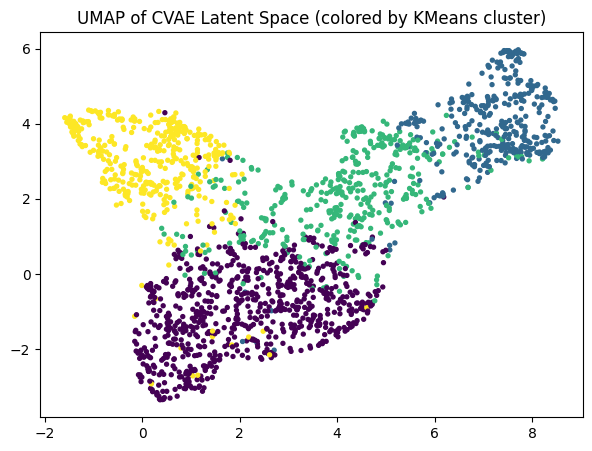

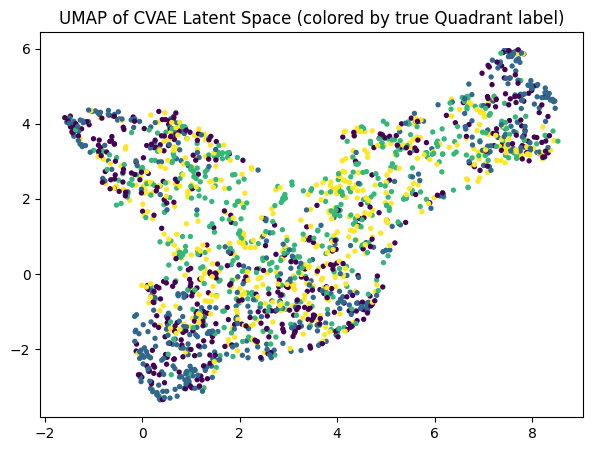

In [ ]:
import umap
import matplotlib.pyplot as plt

emb = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(Z)

plt.figure(figsize=(7,5))
plt.scatter(emb[:,0], emb[:,1], c=C, s=8)
plt.title("UMAP of CVAE Latent Space (colored by KMeans cluster)")
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(emb[:,0], emb[:,1], c=Q, s=8)
plt.title("UMAP of CVAE Latent Space (colored by true Quadrant label)")
plt.show()


In [ ]:
out_dir = "/content/drive/MyDrive/CSE425_VAE_Project/results"
import os
os.makedirs(out_dir, exist_ok=True)

np.save(f"{out_dir}/Z_mu.npy", Z)
np.save(f"{out_dir}/Q_true.npy", Q)
np.save(f"{out_dir}/clusters_kmeans.npy", C)

print("Saved latents and cluster labels to:", out_dir)


Saved latents and cluster labels to: /content/drive/MyDrive/CSE425_VAE_Project/results


In [ ]:
model.eval()


CNN_CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=8196, out_features=32, bias=True)
    (fc_logvar): Linear(in_features=8196, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=36, out_features=8192, bias=True)
    (deconv1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (deconv4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2,

In [ ]:
import torch.nn.functional as F

Mu_list, Qemb_list, Q_list = [], [], []

with torch.no_grad():
    for x, q in loader:
        x = x.to(device, non_blocking=True)
        q = q.to(device, non_blocking=True)

        _, mu, _, _ = model(x, q)
        # Create one-hot encoding for the quadrant, as model does not have a 'q_embed' attribute
        q_onehot = F.one_hot(q, num_classes=4).float()

        Mu_list.append(mu.cpu().numpy())
        Qemb_list.append(q_onehot.cpu().numpy())
        Q_list.append(q.cpu().numpy())

Mu = np.vstack(Mu_list)
Qemb = np.vstack(Qemb_list)
Qtrue = np.concatenate(Q_list)

Z_cond = np.concatenate([Mu, Qemb], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np

def purity_score(y_true, y_pred):
    # y_true and y_pred are 1D numpy arrays
    clusters = np.unique(y_pred)
    total = 0
    for c in clusters:
        idx = np.where(y_pred == c)[0]
        if len(idx) == 0:
            continue
        labels, counts = np.unique(y_true[idx], return_counts=True)
        total += counts.max()
    return total / len(y_true)

Zs = StandardScaler().fit_transform(Z_cond)

kmeans = KMeans(n_clusters=4, n_init=50, random_state=42)
C = kmeans.fit_predict(Zs)

print("ARI:", adjusted_rand_score(Qtrue, C))
print("NMI:", normalized_mutual_info_score(Qtrue, C))
print("Purity:", purity_score(Qtrue, C))

ARI: 0.01112142532467962
NMI: 0.015545193054075484
Purity: 0.31347962382445144


In [ ]:
!pip -q install sentence-transformers


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

tracks_csv = "/content/drive/MyDrive/CSE425_VAE_Project/data/processed/tracks.csv"
out_dir = "/content/drive/MyDrive/CSE425_VAE_Project/data/processed"
os.makedirs(out_dir, exist_ok=True)

lyrics_emb_path = f"{out_dir}/lyrics_sbert.npy"

df = pd.read_csv(tracks_csv)

def read_lyrics(path, max_chars=6000):
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            text = f.read().strip()
        # keep it bounded (SBERT doesn't need super long)
        return text[:max_chars] if text else ""
    except:
        return ""

texts = [read_lyrics(p) for p in df["lyrics_path"].tolist()]

from sentence_transformers import SentenceTransformer
model_sbert = SentenceTransformer("all-MiniLM-L6-v2")  # fast + strong baseline

emb = model_sbert.encode(
    texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

np.save(lyrics_emb_path, emb)
print("Saved SBERT lyrics embeddings:", emb.shape, "->", lyrics_emb_path)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Saved SBERT lyrics embeddings: (1914, 384) -> /content/drive/MyDrive/CSE425_VAE_Project/data/processed/lyrics_sbert.npy


In [ ]:
from sklearn.decomposition import PCA

lyrics_emb = np.load(lyrics_emb_path)  # (N,384)

pca = PCA(n_components=32, random_state=42)
lyrics_32 = pca.fit_transform(lyrics_emb)

print("Lyrics PCA shape:", lyrics_32.shape)
print("Explained variance (sum):", pca.explained_variance_ratio_.sum())


Lyrics PCA shape: (1914, 32)
Explained variance (sum): 0.48820803


In [ ]:
import numpy as np
import torch
from tqdm import tqdm

model.eval()

Mu_list = []
Q_list  = []

with torch.no_grad():
    for x, q in tqdm(loader, desc="Extracting audio mu"):
        x = x.to(device, non_blocking=True)
        q = q.to(device, non_blocking=True)
        _, mu, _, _ = model(x, q)
        Mu_list.append(mu.cpu().numpy())
        Q_list.append(q.cpu().numpy())

Mu_audio = np.vstack(Mu_list)      # (N,32)
Qtrue    = np.concatenate(Q_list)  # (N,)

print("Mu_audio:", Mu_audio.shape, "Qtrue:", Qtrue.shape)


Extracting audio mu: 100%|██████████| 15/15 [00:00<00:00, 17.51it/s]

Mu_audio: (1914, 32) Qtrue: (1914,)


In [ ]:
Z_fused = np.concatenate([Mu_audio, lyrics_32], axis=1)
print("Z_fused shape:", Z_fused.shape)

Z_fused shape: (1914, 64)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import numpy as np

def purity_score(y_true, y_pred):
    clusters = np.unique(y_pred)
    total = 0
    for c in clusters:
        idx = np.where(y_pred == c)[0]
        labels, counts = np.unique(y_true[idx], return_counts=True)
        total += counts.max()
    return total / len(y_true)

Z_fused = np.concatenate([Mu_audio, lyrics_32], axis=1)  # (N,64)
Zs = StandardScaler().fit_transform(Z_fused)

kmeans = KMeans(n_clusters=4, n_init=50, random_state=42)
C = kmeans.fit_predict(Zs)

print("FUSED (Audio CVAE mu + Lyrics SBERT PCA) Results")
print("Silhouette:", silhouette_score(Zs, C))
print("ARI:", adjusted_rand_score(Qtrue, C))
print("NMI:", normalized_mutual_info_score(Qtrue, C))
print("Purity:", purity_score(Qtrue, C))


FUSED (Audio CVAE mu + Lyrics SBERT PCA) Results
Silhouette: 0.058480505
ARI: 0.0060719156300929195
NMI: 0.009697242559203761
Purity: 0.29832810867293624


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


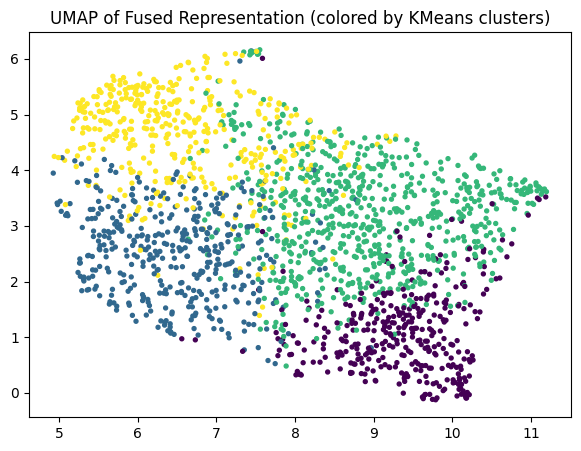

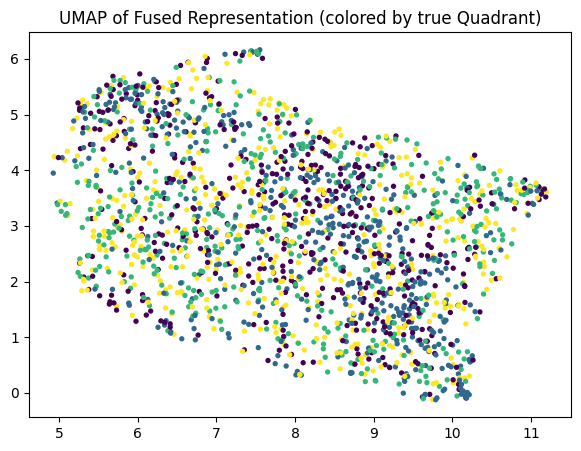

In [ ]:
import umap
import matplotlib.pyplot as plt

emb2d = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42).fit_transform(Zs)

plt.figure(figsize=(7,5))
plt.scatter(emb2d[:,0], emb2d[:,1], c=C, s=8)
plt.title("UMAP of Fused Representation (colored by KMeans clusters)")
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(emb2d[:,0], emb2d[:,1], c=Qtrue, s=8)
plt.title("UMAP of Fused Representation (colored by true Quadrant)")
plt.show()


**PCA+K-means**

In [ ]:
import numpy as np

# Load precomputed mels
X = np.load("/content/drive/MyDrive/CSE425_VAE_Project/data/processed/mels_1x128x128.npy")
Qtrue = np.load("/content/drive/MyDrive/CSE425_VAE_Project/data/processed/quadrants.npy")

# Flatten spectrograms: (N, 1, 128, 128) → (N, 16384)
X_flat = X.reshape(len(X), -1)
print("Flattened shape:", X_flat.shape)


Flattened shape: (1914, 16384)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_flat)

pca = PCA(n_components=32, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("PCA shape:", X_pca.shape)
print("Explained variance:", pca.explained_variance_ratio_.sum())


PCA shape: (1914, 32)
Explained variance: 0.68820345


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

def purity_score(y_true, y_pred):
    total = 0
    for c in np.unique(y_pred):
        idx = np.where(y_pred == c)[0]
        labels, counts = np.unique(y_true[idx], return_counts=True)
        total += counts.max()
    return total / len(y_true)

kmeans = KMeans(n_clusters=4, n_init=50, random_state=42)
C_pca = kmeans.fit_predict(X_pca)

print("PCA + KMeans Results")
print("Silhouette:", silhouette_score(X_pca, C_pca))
print("ARI:", adjusted_rand_score(Qtrue, C_pca))
print("NMI:", normalized_mutual_info_score(Qtrue, C_pca))
print("Purity:", purity_score(Qtrue, C_pca))


PCA + KMeans Results
Silhouette: 0.1539754
ARI: 0.05692986937951694
NMI: 0.08599069234547115
Purity: 0.3793103448275862


**Autoencoder + K-Means** CNN based autoencoder code in src/autoencoder.py

In [ ]:
from src.autoencoder import CNN_Autoencoder
import torch.optim as optim
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Use the SAME precomputed dataset
class AE_Dataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx]

ds_ae = AE_Dataset(X)
loader_ae = torch.utils.data.DataLoader(ds_ae, batch_size=128, shuffle=True)

ae = CNN_Autoencoder(latent_dim=32).to(device)
opt = optim.Adam(ae.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

for epoch in range(15):
    total = 0
    for x in loader_ae:
        x = x.to(device)
        x_hat, _ = ae(x)
        loss = loss_fn(x_hat, x)

        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item()

    print(f"[AE] Epoch {epoch+1}: loss = {total/len(ds_ae):.4f}")


[AE] Epoch 1: loss = 0.0003
[AE] Epoch 2: loss = 0.0002
[AE] Epoch 3: loss = 0.0001
[AE] Epoch 4: loss = 0.0001
[AE] Epoch 5: loss = 0.0001
[AE] Epoch 6: loss = 0.0001
[AE] Epoch 7: loss = 0.0001
[AE] Epoch 8: loss = 0.0001
[AE] Epoch 9: loss = 0.0001
[AE] Epoch 10: loss = 0.0001
[AE] Epoch 11: loss = 0.0001
[AE] Epoch 12: loss = 0.0001
[AE] Epoch 13: loss = 0.0001
[AE] Epoch 14: loss = 0.0001
[AE] Epoch 15: loss = 0.0001


In [ ]:
ae.eval()
Z_ae = []

with torch.no_grad():
    for x in loader_ae:
        x = x.to(device)
        _, z = ae(x)
        Z_ae.append(z.cpu().numpy())

Z_ae = np.vstack(Z_ae)


In [ ]:
from sklearn.preprocessing import StandardScaler

Zs_ae = StandardScaler().fit_transform(Z_ae)

C_ae = KMeans(n_clusters=4, n_init=50, random_state=42).fit_predict(Zs_ae)

print("Autoencoder + KMeans Results")
print("Silhouette:", silhouette_score(Zs_ae, C_ae))
print("ARI:", adjusted_rand_score(Qtrue, C_ae))
print("NMI:", normalized_mutual_info_score(Qtrue, C_ae))
print("Purity:", purity_score(Qtrue, C_ae))


Autoencoder + KMeans Results
Silhouette: 0.17680584
ARI: 0.001654664695767896
NMI: 0.003211653891936176
Purity: 0.28056426332288403
